# O problema

Imagine agora que você foi contratado(a) como Expert em Data Analytics por um grande hospital para entender como foi o comportamento da população na época da pandemia da COVID-19 e quais indicadores seriam importantes para o planejamento, caso haja um novo surto da doença.

Apesar de ser contratado(a) agora, a sua área observou que a utilização do estudo do PNAD-COVID 19 do IBGE seria uma ótima base para termos boas respostas ao problema proposto, pois são dados confiáveis. Porém, não será necessário utilizar todas as perguntas realizadas na pesquisa para enxergar todas as oportunidades ali postas.

É sempre bom ressaltar que há dados triviais que precisam estar no projeto, pois auxiliam muito na análise dos dados:

- Características clínicas dos sintomas;
- Características da população;
- Características econômicas da sociedade.

O Head de Dados pediu para que você entrasse na base de dados do PNAD-COVID-19 do IBGE e organizasse esta base para análise, utilizando Banco de Dados em Nuvem e trazendo as seguintes características:

a. Utilização de no máximo 20 questionamentos realizados na pesquisa;
b. Utilizar 3 meses para construção da solução;
c. Caracterização dos sintomas clínicos da população;
d. Comportamento da população na época da COVID-19;
e. Características econômicas da sociedade.

Seu objetivo será trazer uma breve análise dessas informações, como foi a organização do banco, as perguntas selecionadas para a resposta do problema e quais seriam as principais ações que o hospital deverá tomar em caso de um novo surto de COVID-19.

> **Dica:** Leiam com atenção a base de dados e toda a documentação que o site do PNAD – COVID-19 traz, principalmente os dicionários, que ajudam e muito no entendimento da Base de Dados.

> **Dica 2:** Utilizem o que já foi ensinado e consolidado nas outras fases para apresentar a resolução do projeto.

Lembre-se de que você poderá apresentar o desenvolvimento do seu projeto durante as lives com docentes. Essa é uma boa oportunidade para discutir sobre as dificuldades encontradas e pegar dicas valiosas com especialistas e colegas de turma.

**Não se esqueça que isso é um entregável obrigatório!** Se atente para o prazo de entrega até o final da fase.

**Vamos pra cima!**


## GRUPO

**Grupo 57**

### INTEGRANTES DO GRUPO 57

- **Thiago dos Santos Oliveira**  
  oliveira.thiago345@hotmail.com

- **Felipe Santos Rocha**  
  sr1179281008@live.com

- **Tiago Silva Rodrigues**  
  ti_ago_silva@hotmail.com

- **Bianca Vasconcelos Silva**  
  biavasco.md@gmail.com

In [3]:
# !pip install pyspark

In [4]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pandas as pd

In [5]:
# Criação da sessão Spark
spark = SparkSession.builder \
    .appName("PySpark BigQuery Connection") \
    .config('spark.jars.packages', 'com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.23.2') \
    .config("spark.jars", "/usr/local/lib/spark-connectors/bigquery-connector-hadoop2-latest.jar") \
    .getOrCreate()

24/09/30 18:12:52 WARN Utils: Your hostname, spark-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/09/30 18:12:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/spark/.ivy2/cache
The jars for the packages stored in: /home/spark/.ivy2/jars
com.google.cloud.spark#spark-bigquery-with-dependencies_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-bc4f6ec0-592e-4264-acbe-9164e4985de2;1.0
	confs: [default]
	found com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.23.2 in central
:: resolution report :: resolve 220ms :: artifacts dl 6ms
	:: modules in use:
	com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.23.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	-------------------------------------------------------------------

In [6]:
spark.conf.set("viewsEnabled", True)
spark.conf.set("materializationDataset", "SPEC")

In [7]:
sc = spark.sparkContext
sc.setLogLevel("INFO")
sc._jsc.hadoopConfiguration().set('fs.gs.impl', 'com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem')
sc._jsc.hadoopConfiguration().set('fs.gs.auth.service.account.json.keyfile', '/usr/local/lib/gcp/credentials/my-project-1508437523553-e9bafe7e3368.json')

In [8]:
# Função para salvar DataFrame em formato Parquet
def save_to_bigquery(df, dataset, table_name):
    # Salva o DataFrame em formato Parquet
    df.write \
    .format("bigquery") \
    .option("table", f"{dataset.upper()}.{table_name}") \
    .option("temporaryGcsBucket", "meu-bucket-temporario-spark") \
    .option("credentialsFile", "/usr/local/lib/gcp/credentials/my-project-1508437523553-e9bafe7e3368.json") \
    .mode("overwrite") \
    .save()

In [9]:
# Função para ler dados do BigQuery
def read_from_bigquery(dataset, table_name):  
    df = spark.read \
        .format('bigquery') \
        .option('table', f"{dataset.upper()}.{table_name}") \
        .option("credentialsFile", "/usr/local/lib/gcp/credentials/my-project-1508437523553-e9bafe7e3368.json") \
        .load()

    return df

In [10]:
df = read_from_bigquery('SPEC', 'tbx001_data')
df.createOrReplaceTempView("tbx001_data")

In [11]:
# filtrar pegando o ultimo ano na coluna "ano" e os ultimos 3 meses na coluna "mes"
df = spark.sql("""
    SELECT 
        *
    FROM tbx001_data
    WHERE ano = (SELECT MAX(ano) FROM tbx001_data)
    AND mes IN (SELECT mes FROM tbx001_data WHERE ano = (SELECT MAX(ano) FROM tbx001_data) group by mes ORDER BY mes DESC LIMIT 3)
""")

In [12]:
df.printSchema()

root
 |-- estado: string (nullable = true)
 |-- ano: long (nullable = true)
 |-- mes: long (nullable = true)
 |-- semana: long (nullable = true)
 |-- ano_nascimento: long (nullable = true)
 |-- faixa_etaria: string (nullable = true)
 |-- sexo: string (nullable = true)
 |-- cor_raca: string (nullable = true)
 |-- tipo_area: string (nullable = true)
 |-- escolaridade: string (nullable = true)
 |-- teve_sintomas_covid: string (nullable = true)
 |-- foi_posto_saude: string (nullable = true)
 |-- ficou_em_casa: string (nullable = true)
 |-- ficou_internado: string (nullable = true)
 |-- foi_ao_posto_ou_internado: string (nullable = true)
 |-- teve_covid: string (nullable = true)
 |-- resultado_covid: string (nullable = true)
 |-- tem_plano_saude: string (nullable = true)
 |-- faixa_rendimento: string (nullable = true)
 |-- situacao_domicilio: string (nullable = true)



In [13]:
df_pandas = df.toPandas()

24/09/30 18:13:01 INFO DirectBigQueryRelation: |Querying table my-project-1508437523553.SPEC.tbx001_data, parameters sent from Spark:|requiredColumns=[estado,ano,mes,semana,ano_nascimento,faixa_etaria,sexo,cor_raca,tipo_area,escolaridade,teve_sintomas_covid,foi_posto_saude,ficou_em_casa,ficou_internado,foi_ao_posto_ou_internado,teve_covid,resultado_covid,tem_plano_saude,faixa_rendimento,situacao_domicilio],|filters=[IsNotNull(ano)]
24/09/30 18:13:03 INFO ReadSessionCreator: Read session:{"readSessionName":"projects/my-project-1508437523553/locations/us-east1/sessions/CAISDElFV2NDUHB4eHh3bhoCdngaAnVo","readSessionCreationStartTime":"2024-09-30T21:13:01.325Z","readSessionCreationEndTime":"2024-09-30T21:13:03.382Z","readSessionPrepDuration":930,"readSessionCreationDuration":1127,"readSessionDuration":2057}
24/09/30 18:13:03 INFO ReadSessionCreator: Requested 20000 max partitions, but only received 4 from the BigQuery Storage API for session projects/my-project-1508437523553/locations/us-e

In [14]:
# !pip install matplotlib
# !pip install seaborn
# !pip install pandas numpy


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# Configurando o estilo do gráfico
sns.set(style="whitegrid", context="talk", font_scale=0.8)

In [17]:
# Tamanho da base para conferência
print(f"Quantidade de registros: {len(df_pandas)}")

Quantidade de registros: 1149197


# Análise de Registros de COVID-19

Estamos analisando uma base de registros que contém **1.149.197** ocorrências relacionadas a sintomas e confirmações de COVID-19. Para obter insights mais recentes e relevantes, focamos nos **últimos três meses** de dados disponíveis.

A partir desse filtro, foram realizadas diversas análises para entender melhor os comportamentos e padrões dos casos ao longo do tempo. A seguir, apresentamos um resumo das principais análises realizadas:


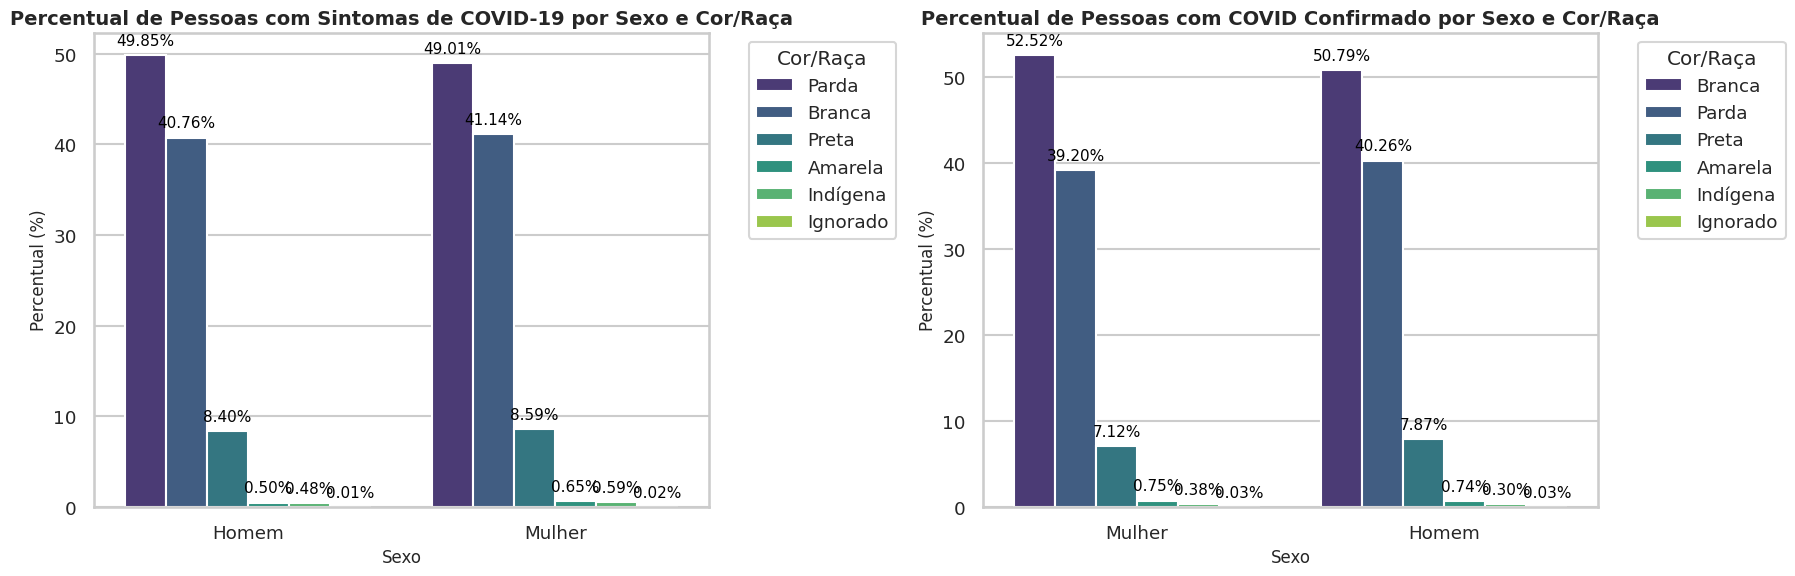

In [18]:
# Filtrando apenas os casos em que a pessoa teve sintomas de COVID-19 ou teve COVID-19 confirmado
df_filtrado = df_pandas[(df_pandas['teve_sintomas_covid'] == 'Sim') | (df_pandas['teve_covid'] == 'Sim')]

# Agrupando por sexo, cor_raca e teve_sintomas_covid para o primeiro gráfico
df_sintomas = df_filtrado.groupby(['sexo', 'cor_raca', 'teve_sintomas_covid']).size().reset_index(name='count')
df_sintomas = df_sintomas[df_sintomas['teve_sintomas_covid'] == 'Sim']
df_sintomas['percentual'] = df_sintomas.groupby(['sexo'])['count'].transform(lambda x: x / x.sum() * 100)

# Agrupando por sexo, cor_raca e teve_covid para o segundo gráfico
df_covid_confirmado = df_filtrado.groupby(['sexo', 'cor_raca', 'teve_covid']).size().reset_index(name='count')
df_covid_confirmado = df_covid_confirmado[df_covid_confirmado['teve_covid'] == 'Sim']
df_covid_confirmado['percentual'] = df_covid_confirmado.groupby(['sexo'])['count'].transform(lambda x: x / x.sum() * 100)

# Ordenando por percentual para exibição clara
df_sintomas = df_sintomas.sort_values(by=['percentual'], ascending=False)
df_covid_confirmado = df_covid_confirmado.sort_values(by=['percentual'], ascending=False)

# Criando a figura com subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 linha, 2 colunas, tamanho total da figura

# Gráfico para pessoas com sintomas de COVID-19
sns.barplot(
    data=df_sintomas,
    x='sexo',
    y='percentual',
    hue='cor_raca',
    palette='viridis',
    ax=axes[0]  # Plotar no primeiro subplot
)
axes[0].set_title('Percentual de Pessoas com Sintomas de COVID-19 por Sexo e Cor/Raça', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sexo', fontsize=12)
axes[0].set_ylabel('Percentual (%)', fontsize=12)
axes[0].legend(title='Cor/Raça', bbox_to_anchor=(1.05, 1), loc='upper left')  # Posicionando a legenda fora do gráfico

# Adicionando os valores no topo das barras para o primeiro gráfico
for p in axes[0].patches:
    height = p.get_height()
    if height > 0:
        axes[0].annotate(f'{height:.2f}%', 
                         (p.get_x() + p.get_width() / 2., height), 
                         ha='center', va='bottom', 
                         fontsize=11, color='black', xytext=(0, 5), 
                         textcoords='offset points')

# Gráfico para pessoas com COVID confirmado
sns.barplot(
    data=df_covid_confirmado,
    x='sexo',
    y='percentual',
    hue='cor_raca',
    palette='viridis',
    ax=axes[1]  # Plotar no segundo subplot
)
axes[1].set_title('Percentual de Pessoas com COVID Confirmado por Sexo e Cor/Raça', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Sexo', fontsize=12)
axes[1].set_ylabel('Percentual (%)', fontsize=12)
axes[1].legend(title='Cor/Raça', bbox_to_anchor=(1.05, 1), loc='upper left')  # Posicionando a legenda fora do gráfico

# Adicionando os valores no topo das barras para o segundo gráfico
for p in axes[1].patches:
    height = p.get_height()
    if height > 0:
        axes[1].annotate(f'{height:.2f}%', 
                         (p.get_x() + p.get_width() / 2., height), 
                         ha='center', va='bottom', 
                         fontsize=11, color='black', xytext=(0, 5), 
                         textcoords='offset points')

# Ajustar layout para evitar sobreposição e mostrar os gráficos
plt.tight_layout()
plt.show()

## Análise de Percentual de Pessoas com Sintomas e COVID Confirmado por Sexo e Cor/Raça

Os gráficos acima apresentam a distribuição percentual de pessoas que tiveram **sintomas de COVID-19** (à esquerda) e **COVID-19 confirmado** (à direita), segmentadas por **sexo** e **cor/raça**.

### Principais Observações:
1. **Predominância de Casos entre Pessoas Brancas e Pardas**:
   - Nos dois gráficos, observamos que a maioria das pessoas que tiveram sintomas ou confirmação de COVID-19 se identificam como **brancas** ou **pardas**.
   - Entre as mulheres, a distribuição é relativamente equilibrada entre essas duas categorias, enquanto entre os homens, pessoas brancas representam uma porcentagem ligeiramente maior.

2. **Baixa Representatividade de Outras Raças**:
   - Pessoas identificadas como **pretas**, **amarelas**, **indígenas** e casos com raça **ignorada** têm percentuais significativamente menores em ambas as análises.
   - Isso pode indicar uma menor prevalência ou subnotificação dos casos nessas populações.

3. **Distribuição por Sexo**:
   - Para ambos os gráficos, os homens e as mulheres apresentam distribuições percentuais similares dentro de cada grupo de cor/raça.
   - No entanto, para os casos confirmados (gráfico à direita), há uma leve tendência de maior percentual de pessoas brancas entre as mulheres.

Esses gráficos ajudam a entender a distribuição dos casos de COVID-19 por características demográficas, como sexo e cor/raça, oferecendo insights que podem ser utilizados para direcionar políticas de saúde pública.


/tmp/ipykernel_7789/440650128.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_7789/440650128.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_7789/440650128.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


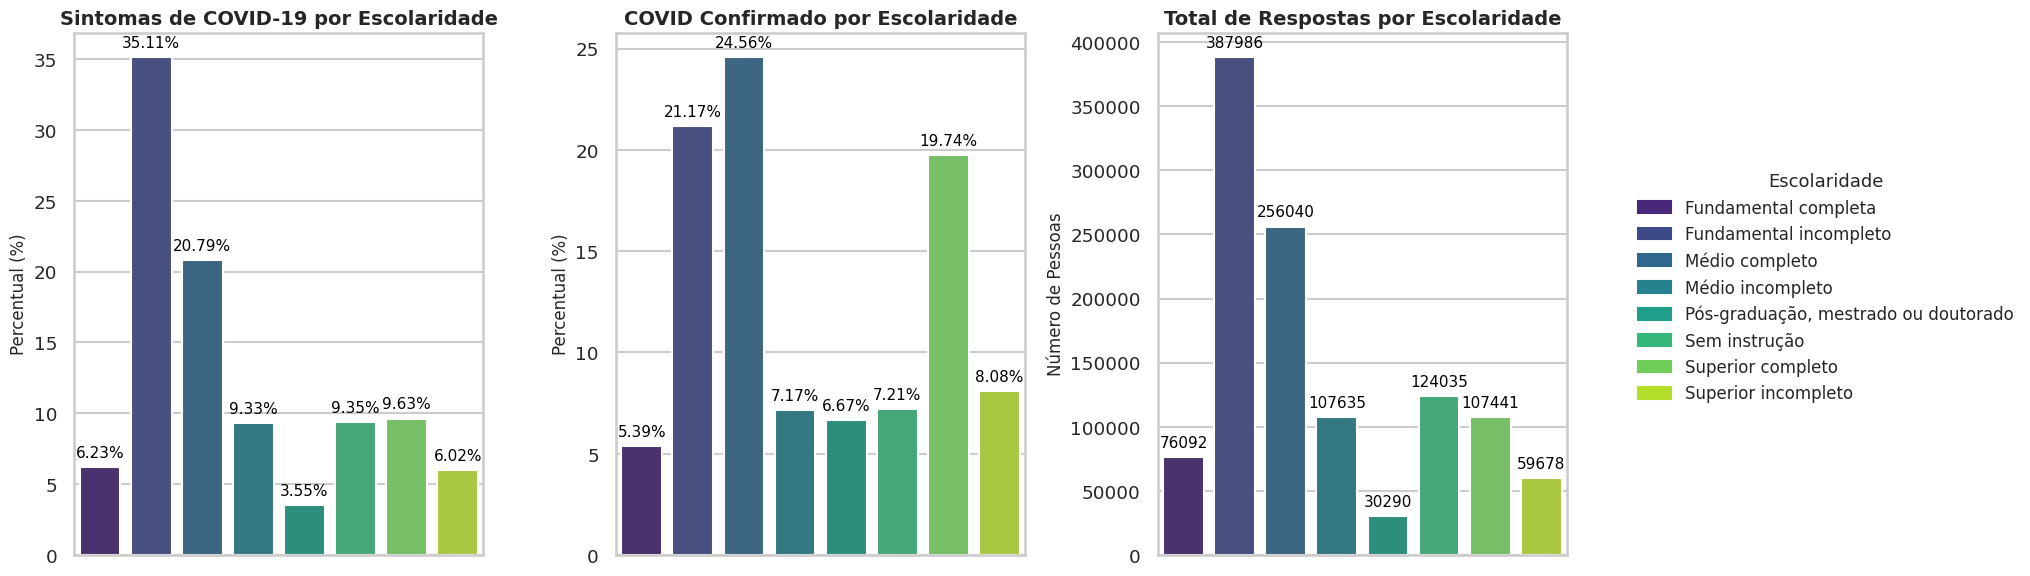

In [19]:
# Filtrando apenas os casos em que a pessoa teve sintomas de COVID-19 ou teve COVID-19 confirmado
df_filtrado_sintomas = df_pandas[df_pandas['teve_sintomas_covid'] == 'Sim']
df_filtrado_covid = df_pandas[df_pandas['teve_covid'] == 'Sim']

# Agrupando por escolaridade para os gráficos
df_sintomas_escolaridade = df_filtrado_sintomas.groupby('escolaridade').size().reset_index(name='count')
df_covid_escolaridade = df_filtrado_covid.groupby('escolaridade').size().reset_index(name='count')
df_total_escolaridade = df_pandas.groupby('escolaridade').size().reset_index(name='count')

# Calculando os percentuais para os gráficos de sintomas e covid confirmado
df_sintomas_escolaridade['percentual'] = (df_sintomas_escolaridade['count'] / df_sintomas_escolaridade['count'].sum()) * 100
df_covid_escolaridade['percentual'] = (df_covid_escolaridade['count'] / df_covid_escolaridade['count'].sum()) * 100

# Criando a figura com 3 subplots lado a lado
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 linha, 3 colunas, tamanho total da figura ajustado

# Gráfico 1: Pessoas que tiveram sintomas de COVID-19 por escolaridade
sns.barplot(
    data=df_sintomas_escolaridade,
    x='escolaridade',
    y='percentual',
    palette='viridis',
    ax=axes[0]
)
axes[0].set_title('Sintomas de COVID-19 por Escolaridade', fontsize=14, fontweight='bold')
axes[0].set_xlabel('')  # Remove rótulo do eixo X
axes[0].set_ylabel('Percentual (%)', fontsize=12)
axes[0].tick_params(axis='x', bottom=False, labelbottom=False)  # Remove os labels e ticks do eixo X
axes[0].legend([], [], frameon=False)  # Remove a legenda individual

# Adicionando os valores no topo das barras para o primeiro gráfico
for p in axes[0].patches:
    height = p.get_height()
    if height > 0:
        axes[0].annotate(f'{height:.2f}%', 
                         (p.get_x() + p.get_width() / 2., height), 
                         ha='center', va='bottom', 
                         fontsize=11, color='black', xytext=(0, 5), 
                         textcoords='offset points')

# Gráfico 2: Pessoas com COVID confirmado por escolaridade
sns.barplot(
    data=df_covid_escolaridade,
    x='escolaridade',
    y='percentual',
    palette='viridis',
    ax=axes[1]
)
axes[1].set_title('COVID Confirmado por Escolaridade', fontsize=14, fontweight='bold')
axes[1].set_xlabel('')  # Remove rótulo do eixo X
axes[1].set_ylabel('Percentual (%)', fontsize=12)
axes[1].tick_params(axis='x', bottom=False, labelbottom=False)  # Remove os labels e ticks do eixo X
axes[1].legend([], [], frameon=False)  # Remove a legenda individual

# Adicionando os valores no topo das barras para o segundo gráfico
for p in axes[1].patches:
    height = p.get_height()
    if height > 0:
        axes[1].annotate(f'{height:.2f}%', 
                         (p.get_x() + p.get_width() / 2., height), 
                         ha='center', va='bottom', 
                         fontsize=11, color='black', xytext=(0, 5), 
                         textcoords='offset points')

# Gráfico 3: Total de pessoas que responderam à pesquisa por escolaridade
sns.barplot(
    data=df_total_escolaridade,
    x='escolaridade',
    y='count',
    palette='viridis',
    ax=axes[2]
)
axes[2].set_title('Total de Respostas por Escolaridade', fontsize=14, fontweight='bold')
axes[2].set_xlabel('')  # Remove rótulo do eixo X
axes[2].set_ylabel('Número de Pessoas', fontsize=12)
axes[2].tick_params(axis='x', bottom=False, labelbottom=False)  # Remove os labels e ticks do eixo X
axes[2].legend([], [], frameon=False)  # Remove a legenda individual

# Adicionando os valores no topo das barras para o terceiro gráfico
for p in axes[2].patches:
    height = p.get_height()
    if height > 0:
        axes[2].annotate(f'{int(height)}', 
                         (p.get_x() + p.get_width() / 2., height), 
                         ha='center', va='bottom', 
                         fontsize=11, color='black', xytext=(0, 5), 
                         textcoords='offset points')

# Ajustar a posição e adicionar uma legenda global para escolaridade à direita
fig.subplots_adjust(right=0.8)  # Ajusta a área dos gráficos para dar espaço para a legenda

# Criar a legenda global à direita dos gráficos
legenda_labels = df_total_escolaridade['escolaridade'].unique()
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in sns.color_palette('viridis', len(legenda_labels))]
# Ajustar posição da legenda para ser centralizada verticalmente
fig.legend(handles, legenda_labels, loc='center right', fontsize=12, title='Escolaridade', title_fontsize='13', frameon=False, bbox_to_anchor=(1.02, 0.5))

# Ajustar layout para evitar sobreposição e mostrar os gráficos
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Ajusta a área do gráfico para dar espaço à legenda

# Exibindo os gráficos
plt.show()

## Análise de Distribuição por Escolaridade

Os gráficos acima apresentam uma comparação da distribuição de **sintomas de COVID-19**, **COVID-19 confirmado** e **respostas totais** de acordo com o nível de escolaridade dos entrevistados.

### Principais Observações:

1. **Sintomas de COVID-19 por Escolaridade**:
   - A maior proporção de pessoas que relataram sintomas de COVID-19 pertence ao grupo com **Fundamental Incompleto** (35,11%), seguido pelo grupo com **Médio Completo** (20,79%).
   - Os grupos de **Superior Completo** e **Pós-graduação, mestrado ou doutorado** apresentam percentuais mais baixos, abaixo de 10%.

2. **COVID-19 Confirmado por Escolaridade**:
   - A distribuição para casos confirmados de COVID-19 é similar ao gráfico de sintomas.
   - O grupo com **Fundamental Incompleto** representa 24,56% dos casos confirmados, seguido pelo grupo com **Superior Completo** (19,74%).

3. **Total de Respostas por Escolaridade**:
   - O gráfico mostra a distribuição total de respostas por nível de escolaridade.
   - A maior quantidade de respostas veio de pessoas com **Fundamental Incompleto** e **Médio Completo**.
   - As menores participações estão entre aqueles com **Médio Incompleto** e **Superior Incompleto**.

Esses gráficos ajudam a identificar padrões entre os diferentes níveis de escolaridade e a prevalência de sintomas e casos confirmados de COVID-19, permitindo direcionar ações mais específicas para cada grupo.


/tmp/ipykernel_7789/3886127271.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top_5_estado_sintomas, x='estado', y='count', palette='viridis', ax=axes[0])
/tmp/ipykernel_7789/3886127271.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top_5_estado_covid, x='estado', y='count', palette='viridis', ax=axes[1])


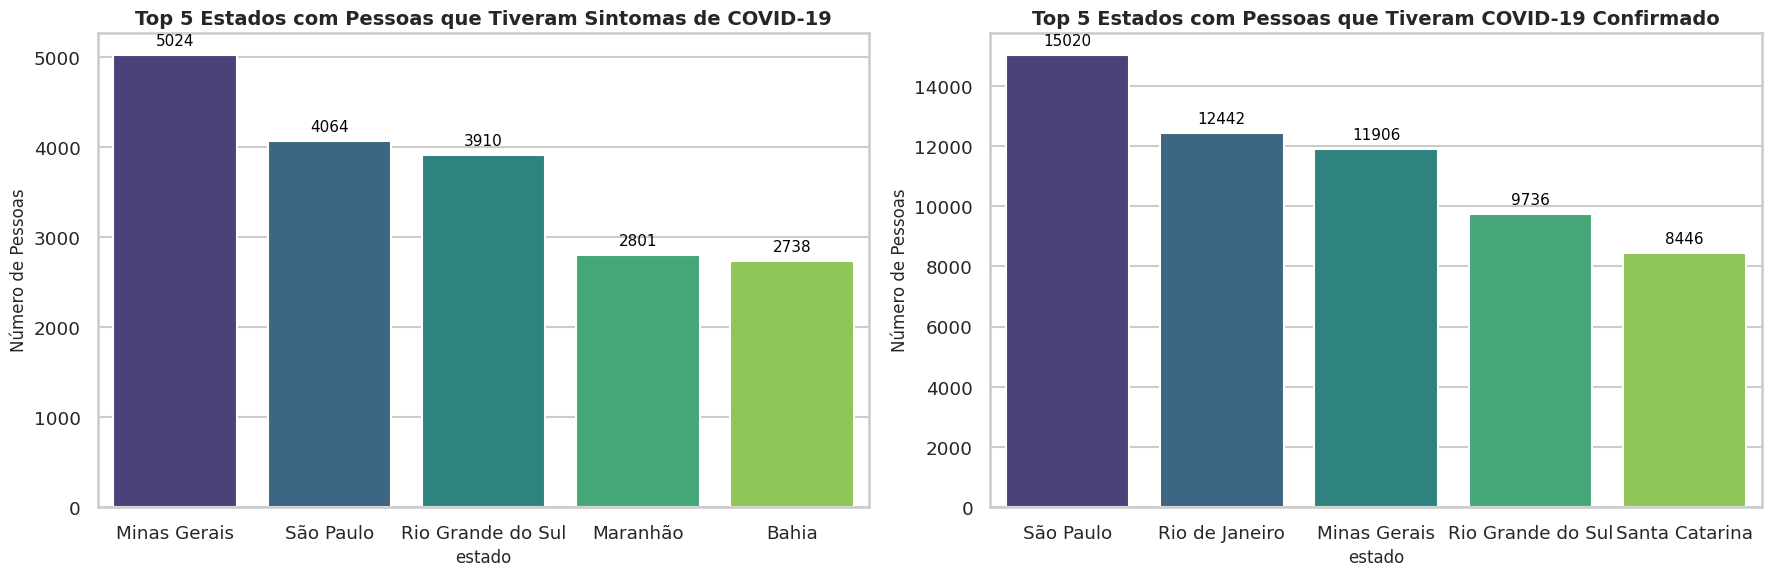

In [20]:
# Filtrando apenas os casos em que a pessoa teve sintomas de COVID-19
df_filtrado_sintomas = df_pandas[df_pandas['teve_sintomas_covid'] == 'Sim']

# Filtrando apenas os casos em que a pessoa teve COVID-19 confirmado
df_filtrado_covid = df_pandas[df_pandas['teve_covid'] == 'Sim']

# Agrupando por estado e contando o número de registros para quem teve sintomas de COVID-19
df_estado_sintomas = df_filtrado_sintomas.groupby('estado').size().reset_index(name='count')

# Agrupando por estado e contando o número de registros para quem teve COVID-19 confirmado
df_estado_covid = df_filtrado_covid.groupby('estado').size().reset_index(name='count')

# Selecionando os 5 maiores valores por estado para cada gráfico
df_top_5_estado_sintomas = df_estado_sintomas.nlargest(5, 'count').sort_values(by='count', ascending=False)
df_top_5_estado_covid = df_estado_covid.nlargest(5, 'count').sort_values(by='count', ascending=False)

# Criando subplots com 1 linha e 2 colunas para os gráficos
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 linha, 2 colunas

# Gráfico 1: Top 5 estados com Pessoas que Tiveram Sintomas de COVID-19
sns.barplot(data=df_top_5_estado_sintomas, x='estado', y='count', palette='viridis', ax=axes[0])
axes[0].set_title('Top 5 Estados com Pessoas que Tiveram Sintomas de COVID-19', fontsize=14, fontweight='bold')
axes[0].set_xlabel('estado', fontsize=12)
axes[0].set_ylabel('Número de Pessoas', fontsize=12)

# Adicionando valores no topo das barras para o gráfico de sintomas
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', 
                     fontsize=11, color='black', xytext=(0, 5), 
                     textcoords='offset points')

# Gráfico 2: Top 5 estados com Pessoas que Tiveram COVID-19 Confirmado
sns.barplot(data=df_top_5_estado_covid, x='estado', y='count', palette='viridis', ax=axes[1])
axes[1].set_title('Top 5 Estados com Pessoas que Tiveram COVID-19 Confirmado', fontsize=14, fontweight='bold')
axes[1].set_xlabel('estado', fontsize=12)
axes[1].set_ylabel('Número de Pessoas', fontsize=12)

# Adicionando valores no topo das barras para o gráfico de COVID confirmado
for p in axes[1].patches:
    axes[1].annotate(f'{int(p.get_height())}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', 
                     fontsize=11, color='black', xytext=(0, 5), 
                     textcoords='offset points')

# Ajustar layout para evitar sobreposição e mostrar os gráficos
plt.tight_layout()
plt.show()

## Análise dos Top 5 Estados com Pessoas que Tiveram Sintomas ou COVID-19 Confirmado

Os gráficos acima apresentam os 5 estados (UFs) com o maior número de pessoas que **tiveram sintomas de COVID-19** e **casos confirmados de COVID-19**.

### Principais Observações:

1. **Sintomas de COVID-19**:
   - **Minas Gerais** lidera com 5.024 casos reportados de pessoas que apresentaram sintomas.
   - **São Paulo** e **Rio Grande do Sul** aparecem em seguida, com 4.064 e 3.910 casos, respectivamente.
   - Os estados **Maranhão** e **Bahia** completam o top 5, com aproximadamente 2.800 casos cada um.

2. **COVID-19 Confirmado**:
   - **São Paulo** se destaca com o maior número de casos confirmados, somando 15.020 registros.
   - **Rio de Janeiro** e **Minas Gerais** ocupam a segunda e terceira posições, com 12.442 e 11.906 casos confirmados, respectivamente.
   - Os estados **Rio Grande do Sul** e **Santa Catarina** fecham o top 5, com menos de 10.000 casos cada.

Esses gráficos demonstram que há uma concentração significativa de casos confirmados e sintomas reportados nas regiões Sudeste e Sul do Brasil, o que pode indicar um foco de disseminação mais intenso nessas áreas. A análise sugere a necessidade de maior atenção e recursos para controle e suporte nas UFs mencionadas.


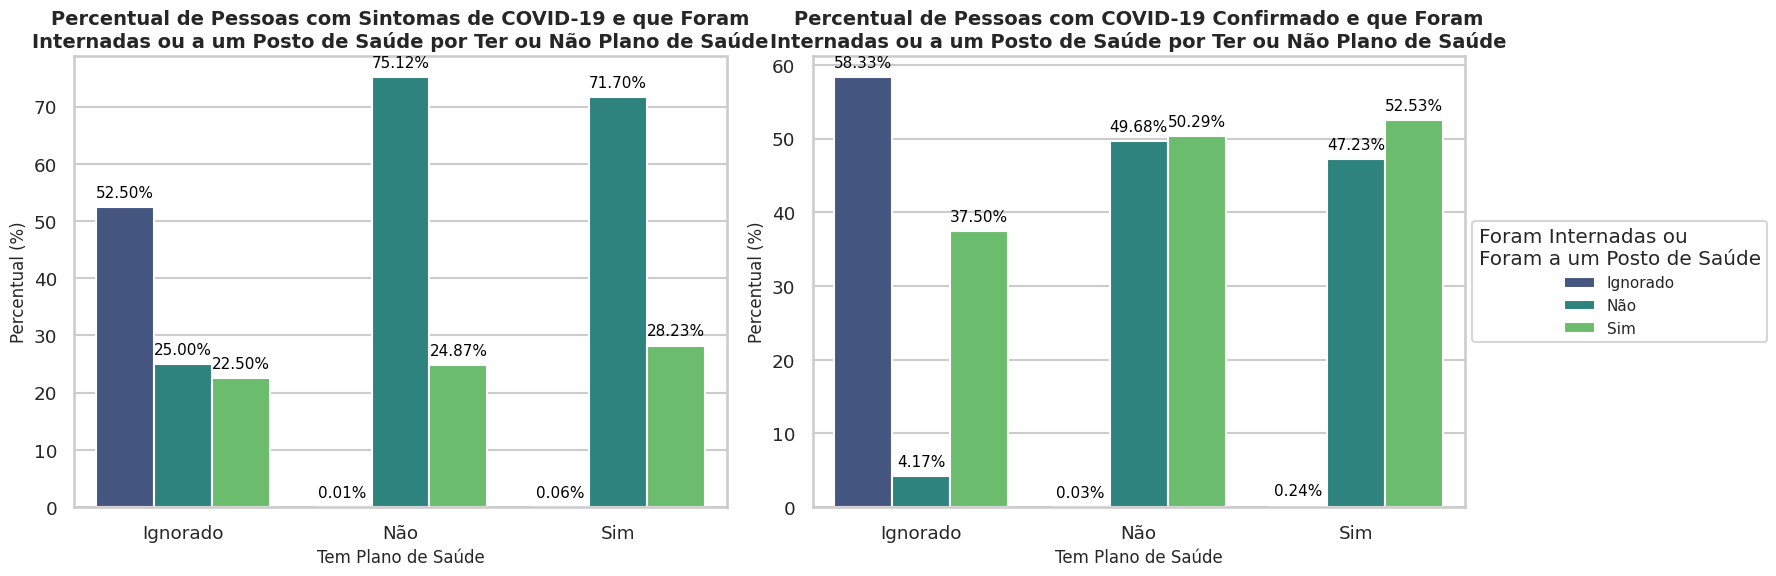

In [21]:
# Filtrando apenas os casos em que a pessoa teve sintomas de COVID-19
df_filtrado_sintomas = df_pandas[df_pandas['teve_sintomas_covid'] == 'Sim']

# Filtrando apenas os casos em que a pessoa teve COVID-19 confirmado
df_filtrado_covid = df_pandas[df_pandas['teve_covid'] == 'Sim']

# Agrupando para obter a contagem por 'tem_plano_saude' e 'foi_ao_posto_ou_internado' para quem teve sintomas de COVID-19
df_sintomas_covid_plano_sintomas = df_filtrado_sintomas.groupby(['tem_plano_saude', 'foi_ao_posto_ou_internado']).size().reset_index(name='count')
df_sintomas_covid_plano_sintomas['percentual'] = df_sintomas_covid_plano_sintomas.groupby('tem_plano_saude')['count'].transform(lambda x: x / x.sum() * 100)

# Agrupando para obter a contagem por 'tem_plano_saude' e 'foi_ao_posto_ou_internado' para quem teve COVID-19 confirmado
df_sintomas_covid_plano_covid = df_filtrado_covid.groupby(['tem_plano_saude', 'foi_ao_posto_ou_internado']).size().reset_index(name='count')
df_sintomas_covid_plano_covid['percentual'] = df_sintomas_covid_plano_covid.groupby('tem_plano_saude')['count'].transform(lambda x: x / x.sum() * 100)

# Criando subplots com 1 linha e 2 colunas para os gráficos
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 linha, 2 colunas, tamanho ajustado

# Gráfico 1: Pessoas que tiveram sintomas de COVID-19 por plano de saúde e hospitalização
sns.barplot(data=df_sintomas_covid_plano_sintomas, x='tem_plano_saude', y='percentual', hue='foi_ao_posto_ou_internado', palette='viridis', ax=axes[0])
axes[0].set_title('Percentual de Pessoas com Sintomas de COVID-19 e que Foram\nInternadas ou a um Posto de Saúde por Ter ou Não Plano de Saúde', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tem Plano de Saúde', fontsize=12)
axes[0].set_ylabel('Percentual (%)', fontsize=12)
axes[0].legend().remove()  # Remove a legenda padrão

# Adicionando valores no topo das barras para o gráfico de sintomas
for p in axes[0].patches:
    height = p.get_height()
    if not pd.isna(height) and height > 0:  # Verifica se a altura não é NaN e se é maior que 0
        axes[0].annotate(f'{height:.2f}%', 
                         (p.get_x() + p.get_width() / 2., height), 
                         ha='center', va='bottom', 
                         fontsize=11, color='black', xytext=(0, 5), 
                         textcoords='offset points')

# Gráfico 2: Pessoas que tiveram COVID-19 confirmado por plano de saúde e hospitalização
sns.barplot(data=df_sintomas_covid_plano_covid, x='tem_plano_saude', y='percentual', hue='foi_ao_posto_ou_internado', palette='viridis', ax=axes[1])
axes[1].set_title('Percentual de Pessoas com COVID-19 Confirmado e que Foram\nInternadas ou a um Posto de Saúde por Ter ou Não Plano de Saúde', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Tem Plano de Saúde', fontsize=12)
axes[1].set_ylabel('Percentual (%)', fontsize=12)
axes[1].legend(title='Foram Internadas ou\nForam a um Posto de Saúde', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=11)

# Adicionando valores no topo das barras para o gráfico de COVID confirmado
for p in axes[1].patches:
    height = p.get_height()
    if not pd.isna(height) and height > 0:  # Verifica se a altura não é NaN e se é maior que 0
        axes[1].annotate(f'{height:.2f}%', 
                         (p.get_x() + p.get_width() / 2., height), 
                         ha='center', va='bottom', 
                         fontsize=11, color='black', xytext=(0, 5), 
                         textcoords='offset points')

# Ajustar layout para evitar sobreposição e mostrar os gráficos
plt.tight_layout()
plt.show()

## Análise da Relação entre Plano de Saúde e Atendimento em Posto de Saúde ou Hospital para Casos de COVID-19

Os gráficos acima apresentam a distribuição percentual de pessoas que **tiveram sintomas de COVID-19** e **COVID-19 confirmado**, analisando se essas pessoas **foram a um posto de saúde ou hospital** e se possuem **plano de saúde**.

### Principais Observações:

1. **Pessoas com Sintomas de COVID-19**:
   - A maioria das pessoas **sem plano de saúde (75,12%)** que tiveram sintomas não procuraram atendimento em postos de saúde ou hospitais.
   - Pessoas **com plano de saúde** apresentam um comportamento semelhante, com **71,70%** não procurando atendimento.

2. **Pessoas com COVID-19 Confirmado**:
   - Entre as pessoas com **COVID-19 confirmado**, o grupo que possui plano de saúde tem um percentual de **52,53%** que procuraram atendimento em postos de saúde ou hospitais.
   - Para aqueles sem plano de saúde, o percentual de quem procurou atendimento é de **50,29%**.

Esses gráficos sugerem que o acesso a atendimento em postos de saúde ou hospitais varia de acordo com a presença ou ausência de plano de saúde. Pessoas com plano de saúde tendem a procurar mais atendimento comparado a quem não possui plano.


/tmp/ipykernel_7789/649060036.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30, ha='right', fontsize=11)
/tmp/ipykernel_7789/649060036.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30, ha='right', fontsize=11)
/tmp/ipykernel_7789/649060036.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_situacao_geral, x='situacao_domicilio', y='percentual', palette='viridis', ax=axes[2])
/tmp/ipykernel_7789/649060036.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLoc

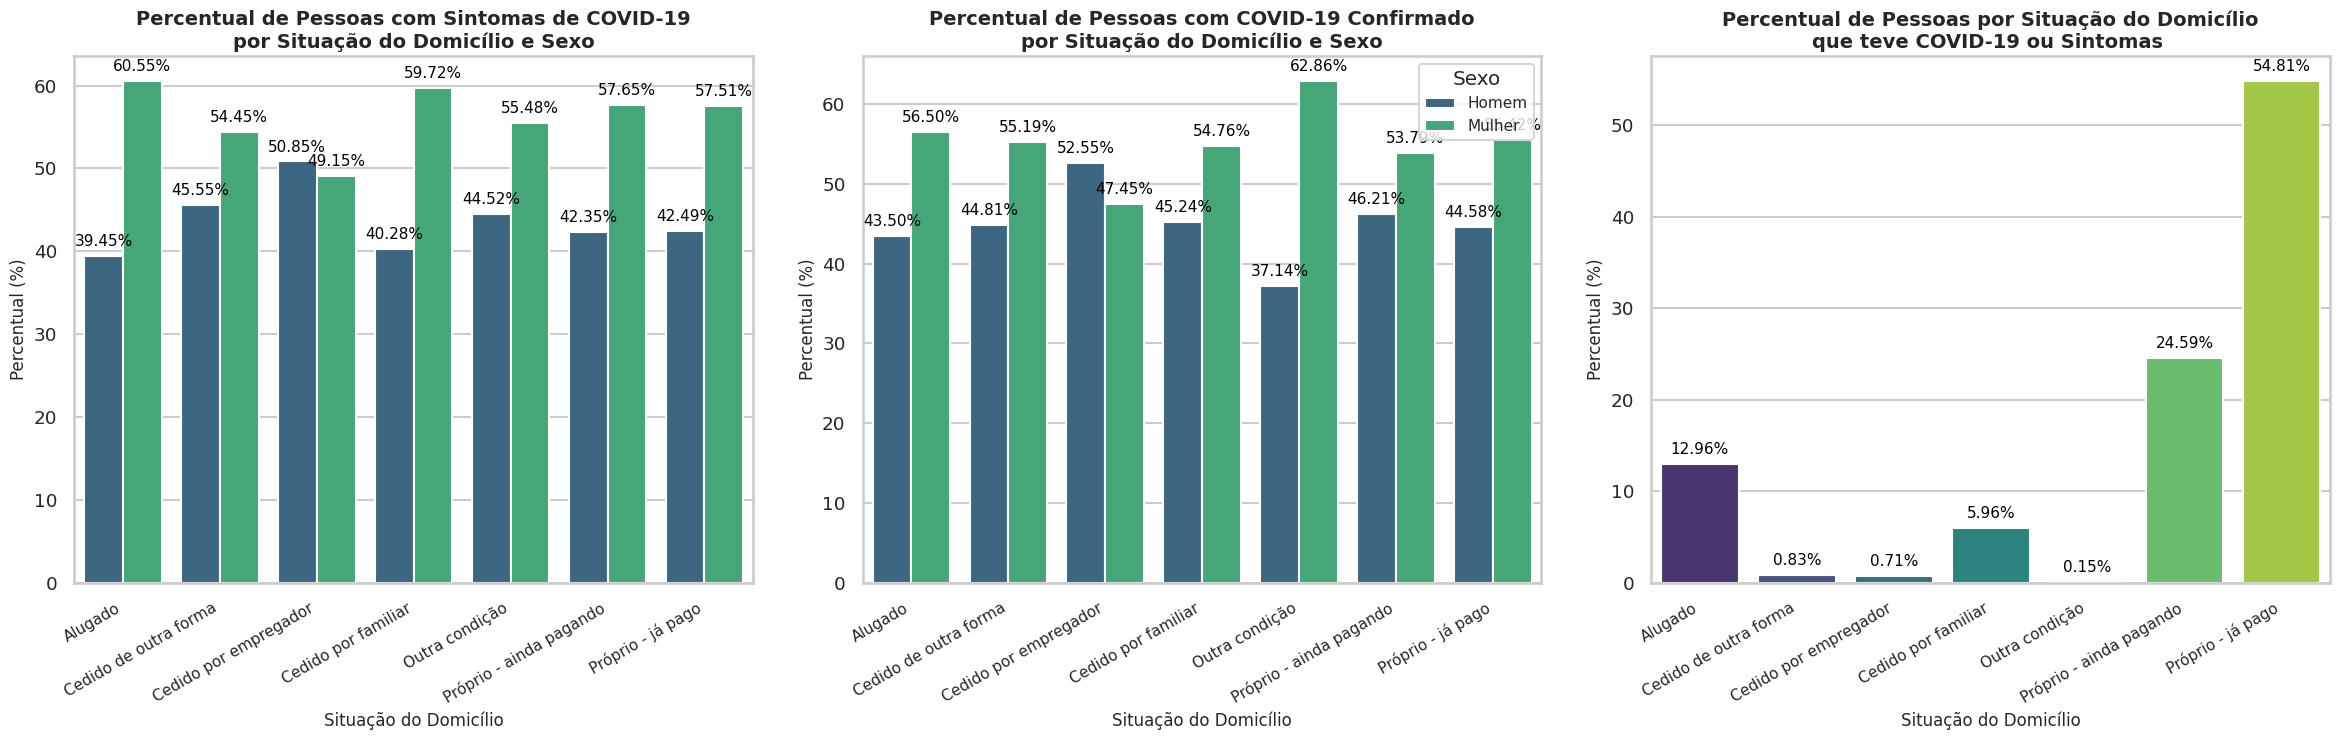

In [22]:
# Filtrando apenas os casos em que a pessoa teve sintomas de COVID-19
df_filtrado_sintomas = df_pandas[df_pandas['teve_sintomas_covid'] == 'Sim']

# Filtrando apenas os casos em que a pessoa teve COVID-19 confirmado
df_filtrado_covid = df_pandas[df_pandas['teve_covid'] == 'Sim']

# Agrupando para obter a contagem por 'situacao_domicilio' e 'sexo' para quem teve sintomas de COVID-19
df_situacao_sintomas = df_filtrado_sintomas.groupby(['situacao_domicilio', 'sexo']).size().reset_index(name='count')
df_situacao_sintomas['percentual'] = df_situacao_sintomas.groupby('situacao_domicilio')['count'].transform(lambda x: x / x.sum() * 100)

# Agrupando para obter a contagem por 'situacao_domicilio' e 'sexo' para quem teve COVID-19 confirmado
df_situacao_covid = df_filtrado_covid.groupby(['situacao_domicilio', 'sexo']).size().reset_index(name='count')
df_situacao_covid['percentual'] = df_situacao_covid.groupby('situacao_domicilio')['count'].transform(lambda x: x / x.sum() * 100)

# Agrupando para obter a contagem total por 'situacao_domicilio' (sem segmentação por sexo)
df_situacao_geral = df_pandas[(df_pandas['teve_covid'] == 'Sim') & (df_pandas['teve_sintomas_covid'] == 'Sim')].groupby(['situacao_domicilio']).size().reset_index(name='count')
df_situacao_geral['percentual'] = (df_situacao_geral['count'] / df_situacao_geral['count'].sum()) * 100

# Criando subplots com 1 linha e 3 colunas para os gráficos
fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # 1 linha, 3 colunas, tamanho ajustado

# Gráfico 1: Pessoas que tiveram sintomas de COVID-19 por situação de domicílio e sexo
sns.barplot(data=df_situacao_sintomas, x='situacao_domicilio', y='percentual', hue='sexo', palette='viridis', ax=axes[0])
axes[0].set_title('Percentual de Pessoas com Sintomas de COVID-19\npor Situação do Domicílio e Sexo', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Situação do Domicílio', fontsize=12)
axes[0].set_ylabel('Percentual (%)', fontsize=12)
axes[0].legend().remove()

# Ajustar rotação e alinhamento dos rótulos do eixo X
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30, ha='right', fontsize=11)

# Adicionando valores no topo das barras para o gráfico de sintomas
for p in axes[0].patches:
    height = p.get_height()
    if not pd.isna(height) and height > 0:  # Verifica se a altura não é NaN e se é maior que 0
        axes[0].annotate(f'{height:.2f}%', 
                         (p.get_x() + p.get_width() / 2., height), 
                         ha='center', va='bottom', 
                         fontsize=11, color='black', xytext=(0, 5), 
                         textcoords='offset points')

# Gráfico 2: Pessoas que tiveram COVID-19 confirmado por situação de domicílio e sexo
sns.barplot(data=df_situacao_covid, x='situacao_domicilio', y='percentual', hue='sexo', palette='viridis', ax=axes[1])
axes[1].set_title('Percentual de Pessoas com COVID-19 Confirmado\npor Situação do Domicílio e Sexo', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Situação do Domicílio', fontsize=12)
axes[1].set_ylabel('Percentual (%)', fontsize=12)
axes[1].legend(title='Sexo', loc='upper right', fontsize=11)

# Ajustar rotação e alinhamento dos rótulos do eixo X
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30, ha='right', fontsize=11)

# Adicionando valores no topo das barras para o gráfico de COVID confirmado
for p in axes[1].patches:
    height = p.get_height()
    if not pd.isna(height) and height > 0:  # Verifica se a altura não é NaN e se é maior que 0
        axes[1].annotate(f'{height:.2f}%', 
                         (p.get_x() + p.get_width() / 2., height), 
                         ha='center', va='bottom', 
                         fontsize=11, color='black', xytext=(0, 5), 
                         textcoords='offset points')

# Gráfico 3: Contagem geral de pessoas por situação de domicílio (sem segmentação por sexo)
sns.barplot(data=df_situacao_geral, x='situacao_domicilio', y='percentual', palette='viridis', ax=axes[2])
axes[2].set_title('Percentual de Pessoas por Situação do Domicílio\nque teve COVID-19 ou Sintomas ', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Situação do Domicílio', fontsize=12)
axes[2].set_ylabel('Percentual (%)', fontsize=12)

# Ajustar rotação e alinhamento dos rótulos do eixo X
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=30, ha='right', fontsize=11)

# Adicionando valores no topo das barras para o gráfico geral
for p in axes[2].patches:
    height = p.get_height()
    if not pd.isna(height) and height > 0:  # Verifica se a altura não é NaN e se é maior que 0
        axes[2].annotate(f'{height:.2f}%', 
                         (p.get_x() + p.get_width() / 2., height), 
                         ha='center', va='bottom', 
                         fontsize=11, color='black', xytext=(0, 5), 
                         textcoords='offset points')

# Ajustar layout para evitar sobreposição e garantir uma melhor visualização
plt.tight_layout(pad=2)  # Ajuste adicional para evitar sobreposição
plt.show()

## Análise de Pessoas com Sintomas e COVID-19 Confirmado por Situação do Domicílio e Sexo

Os gráficos acima mostram a distribuição percentual de pessoas com **sintomas de COVID-19** e **COVID-19 confirmado** segmentados por **situação do domicílio** e **sexo**. Além disso, há um gráfico geral que combina ambos os grupos para mostrar a distribuição total.

### Principais Observações:

1. **Pessoas com Sintomas de COVID-19**:
   - As mulheres tiveram uma maior prevalência de sintomas em quase todas as situações de domicílio, especialmente em domicílios **alugados (60,55%)** e **cedidos por familiar (59,72%)**.
   - Para homens, os percentuais são ligeiramente menores, mas com destaque em **próprios ainda pagando (42,35%)**.

2. **Pessoas com COVID-19 Confirmado**:
   - A maior concentração de casos confirmados foi em domicílios **próprios - já pago** onde as mulheres representam **55%**.
   - A diferença entre os sexos é mais acentuada em domicílios **Outra condição**, sendo as mulheres predominates.

3. **Distribuição Geral (Sintomas e COVID-19 Confirmado)**:
   - A maioria das pessoas com sintomas ou casos confirmados residem em domicílios **próprios já pagos (54,81%)**, seguidos por **próprios ainda pagando (24,59%)**, sugerindo que esses grupos estão mais vulneráveis ao COVID-19.
   - Domicílios alugados também apresentaram uma parcela significativa (12,96%).

Essas análises ajudam a entender como as condições de moradia podem estar relacionadas com a incidência de COVID-19, indicando a necessidade de ações específicas em certos tipos de domicílio.


/tmp/ipykernel_7789/3967882935.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_faixa_etaria_sintomas, x='faixa_etaria', y='percentual', palette='viridis', ax=axes[0, 0])
/tmp/ipykernel_7789/3967882935.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_faixa_etaria_covid, x='faixa_etaria', y='percentual', palette='viridis', ax=axes[0, 1])
/tmp/ipykernel_7789/3967882935.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_faixa_etaria_homem, x='faixa_etaria', y='percentual', palette='viridis', ax=axes[1, 0])
/tmp

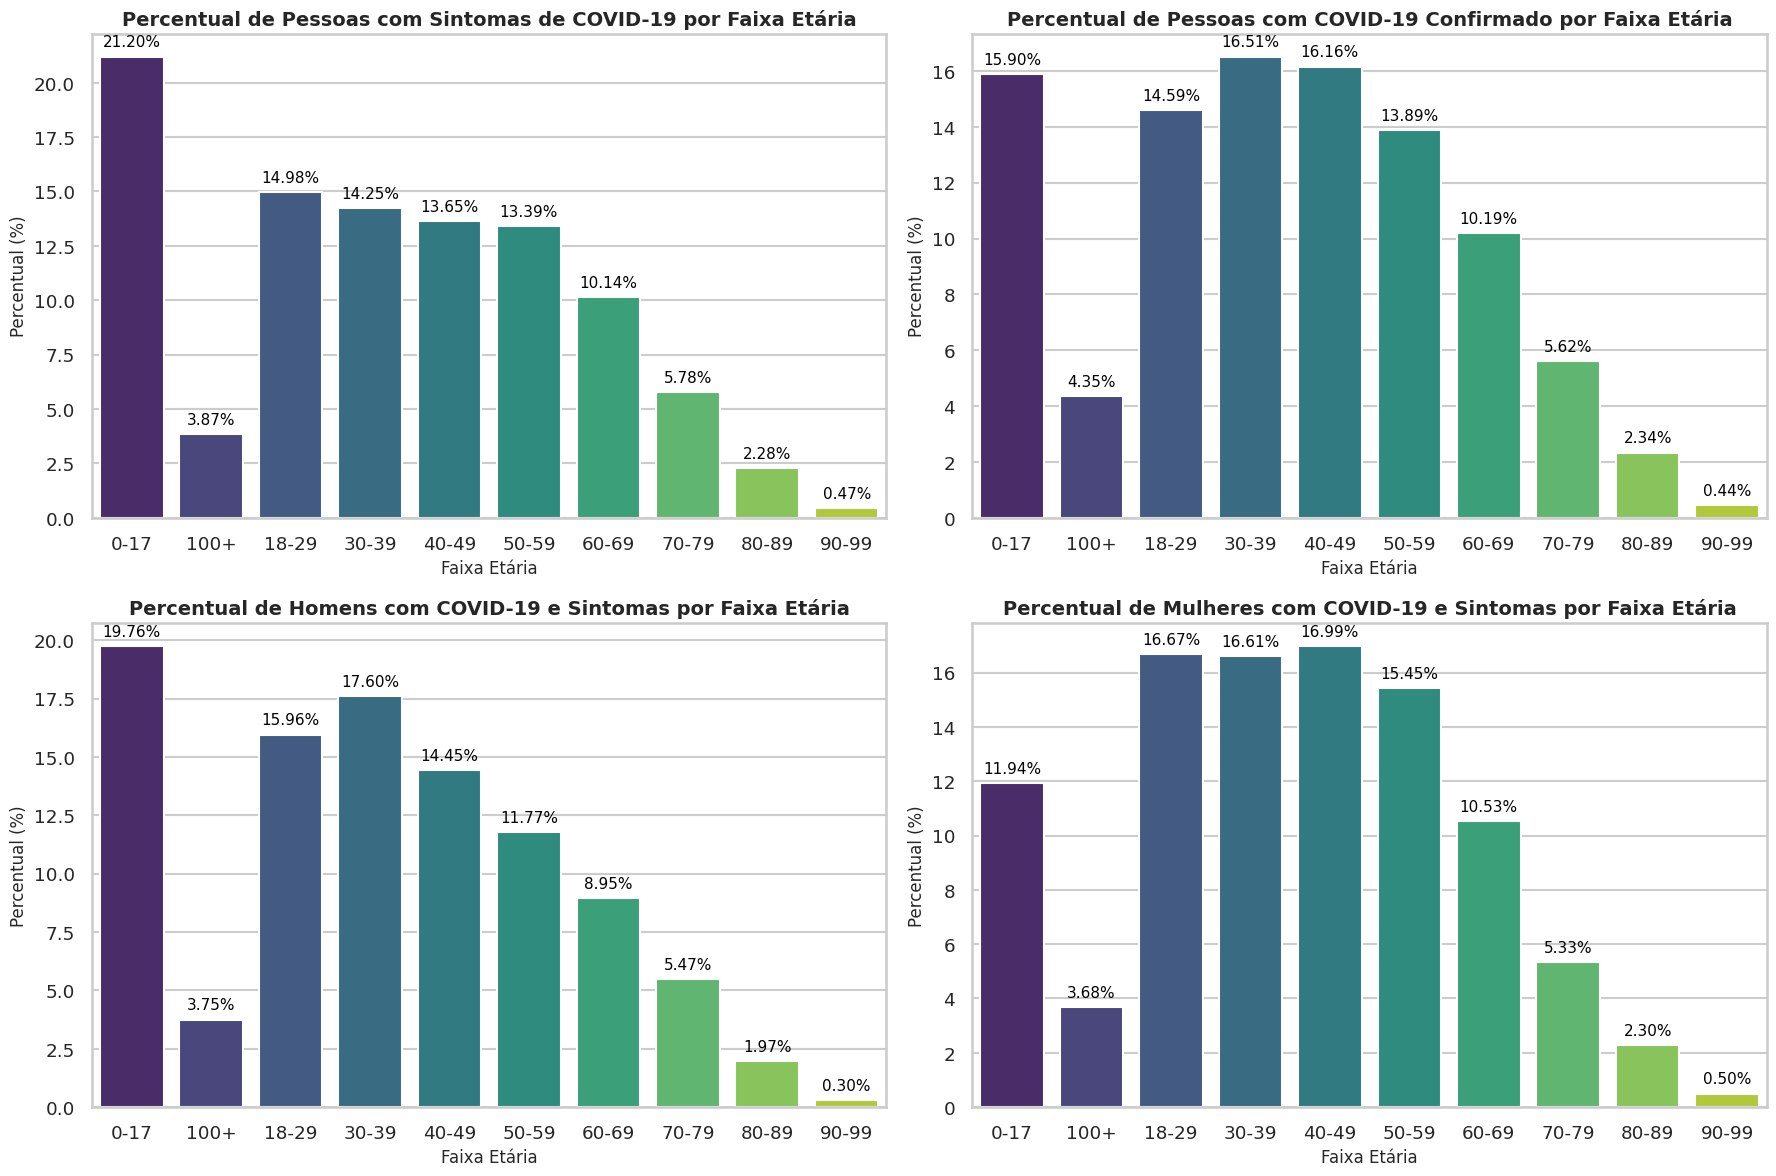

In [23]:
# Filtrando apenas os casos em que a pessoa teve sintomas de COVID-19
df_filtrado_sintomas = df_pandas[df_pandas['teve_sintomas_covid'] == 'Sim']

# Filtrando apenas os casos em que a pessoa teve COVID-19 confirmado
df_filtrado_covid = df_pandas[df_pandas['teve_covid'] == 'Sim']

# Agrupando para obter a contagem por 'faixa_etaria' para quem teve sintomas de COVID-19
df_faixa_etaria_sintomas = df_filtrado_sintomas.groupby(['faixa_etaria']).size().reset_index(name='count')
df_faixa_etaria_sintomas['percentual'] = (df_faixa_etaria_sintomas['count'] / df_faixa_etaria_sintomas['count'].sum()) * 100

# Agrupando para obter a contagem por 'faixa_etaria' para quem teve COVID-19 confirmado
df_faixa_etaria_covid = df_filtrado_covid.groupby(['faixa_etaria']).size().reset_index(name='count')
df_faixa_etaria_covid['percentual'] = (df_faixa_etaria_covid['count'] / df_faixa_etaria_covid['count'].sum()) * 100

# Filtrando dados para homens que tiveram COVID-19 e sintomas
df_filtrado_homem = df_pandas[(df_pandas['teve_covid'] == 'Sim') & (df_pandas['teve_sintomas_covid'] == 'Sim') & (df_pandas['sexo'] == 'Homem')]

# Filtrando dados para mulheres que tiveram COVID-19 e sintomas
df_filtrado_mulher = df_pandas[(df_pandas['teve_covid'] == 'Sim') & (df_pandas['teve_sintomas_covid'] == 'Sim') & (df_pandas['sexo'] == 'Mulher')]

# Agrupando por faixa etária para homens
df_faixa_etaria_homem = df_filtrado_homem.groupby(['faixa_etaria']).size().reset_index(name='count')
df_faixa_etaria_homem['percentual'] = (df_faixa_etaria_homem['count'] / df_faixa_etaria_homem['count'].sum()) * 100

# Agrupando por faixa etária para mulheres
df_faixa_etaria_mulher = df_filtrado_mulher.groupby(['faixa_etaria']).size().reset_index(name='count')
df_faixa_etaria_mulher['percentual'] = (df_faixa_etaria_mulher['count'] / df_faixa_etaria_mulher['count'].sum()) * 100

# Criando subplots com 2 linhas e 2 colunas para os gráficos
fig, axes = plt.subplots(2, 2, figsize=(18, 12))  # 2 linhas, 2 colunas, tamanho ajustado

# Gráfico 1: Pessoas que tiveram sintomas de COVID-19 por faixa etária
sns.barplot(data=df_faixa_etaria_sintomas, x='faixa_etaria', y='percentual', palette='viridis', ax=axes[0, 0])
axes[0, 0].set_title('Percentual de Pessoas com Sintomas de COVID-19 por Faixa Etária', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Faixa Etária', fontsize=12)
axes[0, 0].set_ylabel('Percentual (%)', fontsize=12)

# Adicionando valores no topo das barras para o gráfico de sintomas
for p in axes[0, 0].patches:
    height = p.get_height()
    if not pd.isna(height) and height > 0:
        axes[0, 0].annotate(f'{height:.2f}%', 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha='center', va='bottom', 
                            fontsize=11, color='black', xytext=(0, 5), 
                            textcoords='offset points')

# Gráfico 2: Pessoas que tiveram COVID-19 confirmado por faixa etária
sns.barplot(data=df_faixa_etaria_covid, x='faixa_etaria', y='percentual', palette='viridis', ax=axes[0, 1])
axes[0, 1].set_title('Percentual de Pessoas com COVID-19 Confirmado por Faixa Etária', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Faixa Etária', fontsize=12)
axes[0, 1].set_ylabel('Percentual (%)', fontsize=12)

# Adicionando valores no topo das barras para o gráfico de COVID confirmado
for p in axes[0, 1].patches:
    height = p.get_height()
    if not pd.isna(height) and height > 0:
        axes[0, 1].annotate(f'{height:.2f}%', 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha='center', va='bottom', 
                            fontsize=11, color='black', xytext=(0, 5), 
                            textcoords='offset points')

# Gráfico 3: Homens com COVID-19 e sintomas por faixa etária
sns.barplot(data=df_faixa_etaria_homem, x='faixa_etaria', y='percentual', palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('Percentual de Homens com COVID-19 e Sintomas por Faixa Etária', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Faixa Etária', fontsize=12)
axes[1, 0].set_ylabel('Percentual (%)', fontsize=12)

# Adicionando valores no topo das barras para o gráfico de homens
for p in axes[1, 0].patches:
    height = p.get_height()
    if not pd.isna(height) and height > 0:
        axes[1, 0].annotate(f'{height:.2f}%', 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha='center', va='bottom', 
                            fontsize=11, color='black', xytext=(0, 5), 
                            textcoords='offset points')

# Gráfico 4: Mulheres com COVID-19 e sintomas por faixa etária
sns.barplot(data=df_faixa_etaria_mulher, x='faixa_etaria', y='percentual', palette='viridis', ax=axes[1, 1])
axes[1, 1].set_title('Percentual de Mulheres com COVID-19 e Sintomas por Faixa Etária', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Faixa Etária', fontsize=12)
axes[1, 1].set_ylabel('Percentual (%)', fontsize=12)

# Adicionando valores no topo das barras para o gráfico de mulheres
for p in axes[1, 1].patches:
    height = p.get_height()
    if not pd.isna(height) and height > 0:
        axes[1, 1].annotate(f'{height:.2f}%', 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha='center', va='bottom', 
                            fontsize=11, color='black', xytext=(0, 5), 
                            textcoords='offset points')

# Ajustar layout para evitar sobreposição e garantir uma melhor visualização
plt.tight_layout()
plt.show()

### Análise de Pessoas com Sintomas e COVID-19 Confirmado por Faixa Etária e Sexo:

1. **Primeira Linha**:
   - **Gráfico 1 (Esquerda)**: Percentual de pessoas com sintomas de COVID-19 por faixa etária. Observa-se que as faixas etárias mais afetadas por sintomas são de 0-17 anos (22,05%) e 18-29 anos (15,58%).
   - **Gráfico 2 (Direita)**: Percentual de pessoas com COVID-19 confirmado por faixa etária. As faixas etárias com maior incidência de COVID-19 confirmado são 30-39 anos (17,26%) e 40-49 anos (16,89%).

2. **Segunda Linha**:
   - **Gráfico 3 (Esquerda)**: Percentual de homens com sintomas e COVID-19 confirmado por faixa etária. A faixa etária 0-17 anos apresenta a maior porcentagem (20,53%), seguida por 18-29 anos (16,58%). Isso indica um impacto maior entre os mais jovens.
   - **Gráfico 4 (Direita)**: Percentual de mulheres com sintomas e COVID-19 confirmado por faixa etária. As faixas 18-29 anos (17,30%) e 30-39 anos (17,24%) se destacam como as mais afetadas entre as mulheres.


Os gráficos mostram que a distribuição de sintomas e casos confirmados de COVID-19 varia significativamente entre diferentes faixas etárias e entre homens e mulheres. 

- **Faixa Etária**: As faixas etárias mais jovens (0-17 e 18-29 anos) apresentaram maior incidência de sintomas, enquanto as faixas de 30-49 anos foram as mais afetadas em casos confirmados de COVID-19.
- **Diferença por Sexo**: A análise por sexo revelou que tanto homens quanto mulheres seguem uma distribuição similar em termos de sintomas e casos confirmados, porém com leve predominância de sintomas entre mulheres nas faixas de 18-39 anos e entre homens na faixa de 0-17 anos.

Esses resultados indicam a importância de considerar fatores como idade e sexo ao avaliar a disseminação do COVID-19 e ao implementar estratégias de prevenção e combate à doença. Essa análise pode ser usada para orientar políticas públicas e ações específicas para grupos mais vulneráveis.



/tmp/ipykernel_7789/554012407.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')  # Rotacionar rótulos para evitar sobreposição
/tmp/ipykernel_7789/554012407.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')  # Rotacionar rótulos para evitar sobreposição


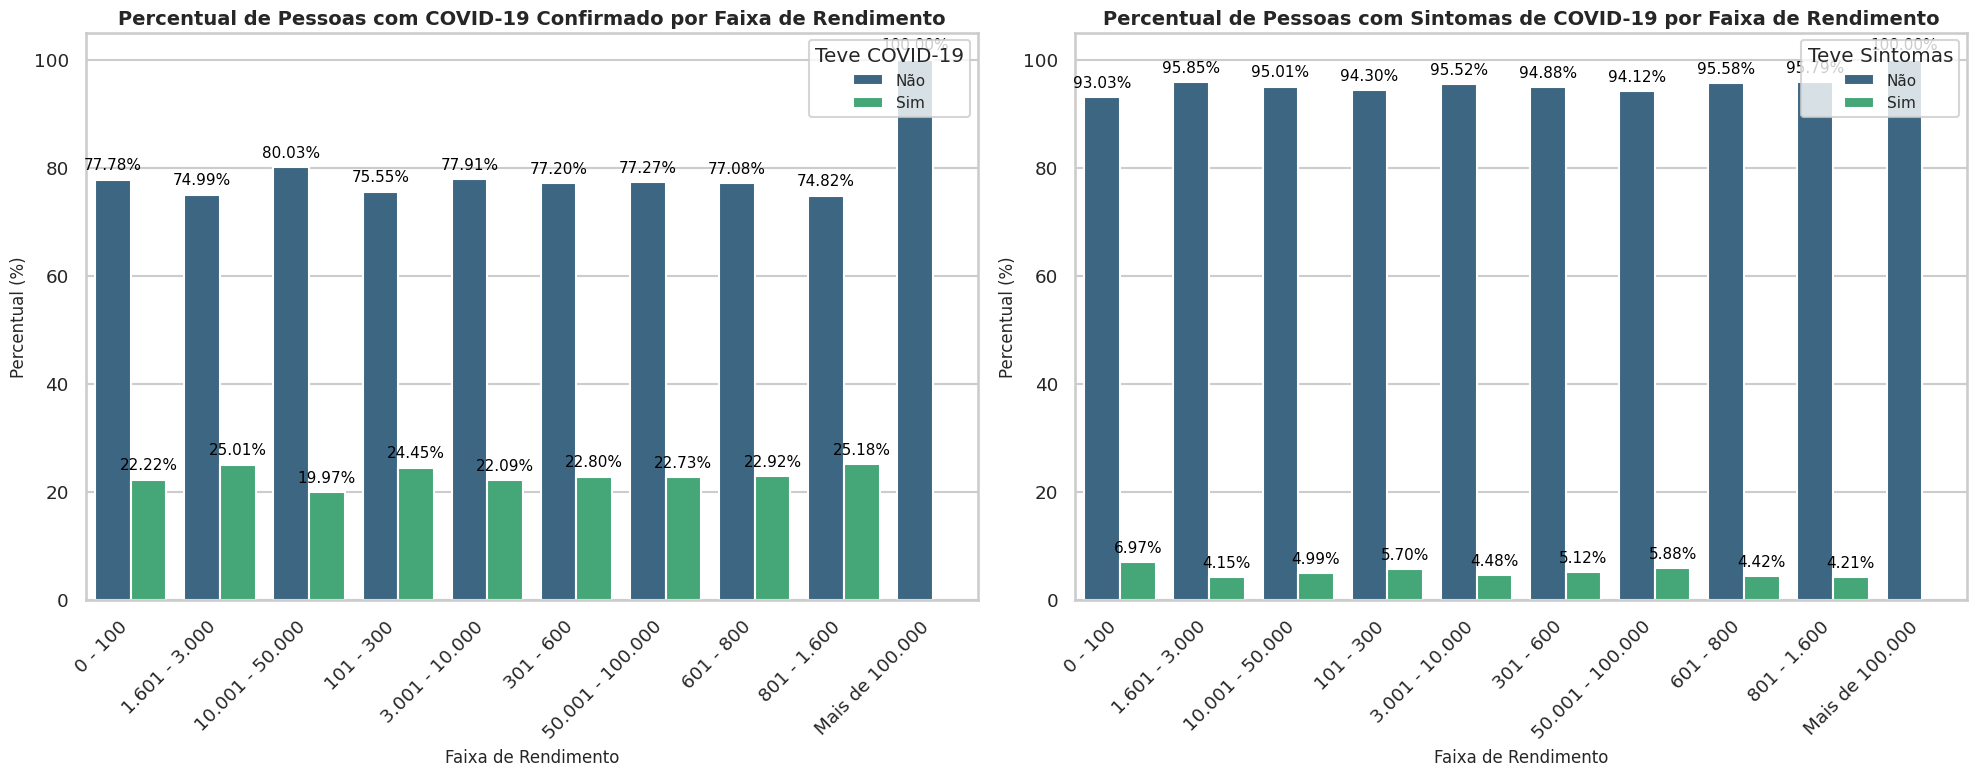

In [24]:
# Agrupando e calculando percentuais para 'teve_covid' por 'faixa_rendimento'
df_teve_covid = df_pandas.groupby(['faixa_rendimento', 'teve_covid']).size().reset_index(name='count')
df_teve_covid['percentual'] = df_teve_covid.groupby('faixa_rendimento')['count'].transform(lambda x: (x / x.sum()) * 100)

# Agrupando e calculando percentuais para 'teve_sintomas_covid' por 'faixa_rendimento'
df_teve_sintomas_covid = df_pandas.groupby(['faixa_rendimento', 'teve_sintomas_covid']).size().reset_index(name='count')
df_teve_sintomas_covid['percentual'] = df_teve_sintomas_covid.groupby('faixa_rendimento')['count'].transform(lambda x: (x / x.sum()) * 100)

# Ajuste no código para evitar sobreposição das legendas
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # Aumentando o tamanho do gráfico para evitar sobreposição

# Gráfico 1: Percentual de pessoas que tiveram COVID-19 por faixa de rendimento
sns.barplot(data=df_teve_covid, x='faixa_rendimento', y='percentual', hue='teve_covid', palette='viridis', ax=axes[0])
axes[0].set_title('Percentual de Pessoas com COVID-19 Confirmado por Faixa de Rendimento', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Faixa de Rendimento', fontsize=12)
axes[0].set_ylabel('Percentual (%)', fontsize=12)
axes[0].legend(title='Teve COVID-19', fontsize=11, loc='upper right')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')  # Rotacionar rótulos para evitar sobreposição

# Adicionando valores no topo das barras
for p in axes[0].patches:
    height = p.get_height()
    if not pd.isna(height) and height > 0:
        axes[0].annotate(f'{height:.2f}%', (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

# Gráfico 2: Percentual de pessoas que tiveram sintomas de COVID-19 por faixa de rendimento
sns.barplot(data=df_teve_sintomas_covid, x='faixa_rendimento', y='percentual', hue='teve_sintomas_covid', palette='viridis', ax=axes[1])
axes[1].set_title('Percentual de Pessoas com Sintomas de COVID-19 por Faixa de Rendimento', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Faixa de Rendimento', fontsize=12)
axes[1].set_ylabel('Percentual (%)', fontsize=12)
axes[1].legend(title='Teve Sintomas', fontsize=11, loc='upper right')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')  # Rotacionar rótulos para evitar sobreposição

# Adicionando valores no topo das barras
for p in axes[1].patches:
    height = p.get_height()
    if not pd.isna(height) and height > 0:
        axes[1].annotate(f'{height:.2f}%', (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

# Ajustar layout para evitar sobreposição e garantir uma melhor visualização
plt.tight_layout()
plt.show()

### Análise de Pessoas com Sintomas e COVID-19 Confirmado por Fixa de Rendimento

1. **Percentual de Pessoas com COVID-19 Confirmado por Faixa de Rendimento**:
   - A maior parte das pessoas em todas as faixas de rendimento não teve COVID-19 confirmado.
   - As faixas de rendimento entre 0-100 e 1.601-3.000 possuem os maiores percentuais de pessoas que tiveram COVID-19 confirmado (22,22% e 25,01%, respectivamente).
   - A menor incidência de confirmação de COVID-19 está na faixa de rendimento entre 10.001-50.000 (19,97%).

2. **Percentual de Pessoas com Sintomas de COVID-19 por Faixa de Rendimento**:
   - A maioria das pessoas em todas as faixas de rendimento não apresentou sintomas de COVID-19.
   - O menor percentual de sintomas foi observado na faixa de rendimento entre 10.001-50.000 (4,15%).
   - As faixas de rendimento mais baixas (0-100 e 1.601-3.000) apresentam percentuais mais elevados de sintomas (6,97% e 4,15%, respectivamente).

Os gráficos mostram que, independentemente da faixa de rendimento, a maior parte da população não teve COVID-19 confirmado nem sintomas. No entanto, os percentuais de sintomas e de confirmação variam ligeiramente entre as faixas de rendimento mais baixas e mais altas.


In [31]:
# Converter os números dos meses para nomes dos meses em português
meses_nome = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril',
    5: 'Maio', 6: 'Junho', 7: 'Julho', 8: 'Agosto',
    9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'
}

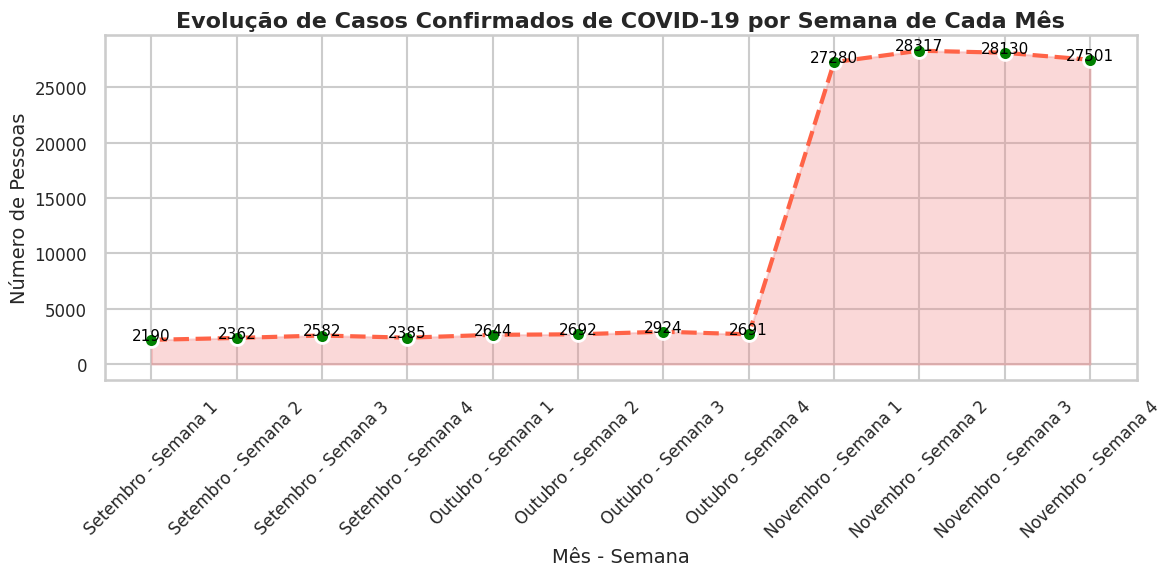

In [32]:
# Filtrando apenas os casos em que a pessoa teve COVID-19 confirmado
df_filtrado_covid = df_pandas[df_pandas['teve_covid'] == 'Sim']

# Agrupando por mês e semana do mês para obter a contagem de casos confirmados de COVID-19
df_evolucao_covid = df_filtrado_covid.groupby(['mes', 'semana']).size().reset_index(name='count')

# Converter os números dos meses para nomes dos meses em português
df_evolucao_covid['mes_nome'] = df_evolucao_covid['mes'].map(meses_nome)

# Criando a coluna 'mes_semana' para facilitar o plot
df_evolucao_covid['mes_semana'] = df_evolucao_covid['mes_nome'] + ' - Semana ' + df_evolucao_covid['semana'].astype(str)

# Ordenando o DataFrame por mês e semana para garantir a sequência correta
df_evolucao_covid = df_evolucao_covid.sort_values(['mes', 'semana'])

# Criando o gráfico de linhas para mostrar a evolução de casos confirmados por semana do mês
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=df_evolucao_covid,
    x='mes_semana', y='count',
    marker='o', color='tomato',
    markersize=10, linewidth=3,
    markerfacecolor='green', markeredgewidth=2,
    linestyle='--'
)

# Adicionando área de preenchimento sob a curva para destaque
ax.fill_between(df_evolucao_covid['mes_semana'], df_evolucao_covid['count'], color='lightcoral', alpha=0.3)

# Adicionando rótulos e título ao gráfico
plt.title('Evolução de Casos Confirmados de COVID-19 por Semana de Cada Mês', fontsize=16, fontweight='bold')
plt.xlabel('Mês - Semana', fontsize=14)
plt.ylabel('Número de Pessoas', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Adicionando valores nos pontos da linha
for index, row in df_evolucao_covid.iterrows():
    plt.text(row['mes_semana'], row['count'] + 0.5, f"{int(row['count'])}", color='black', ha="center", fontsize=11)

# Ajustar layout e exibir o gráfico
plt.tight_layout()
plt.show()


### Evolução de Casos Confirmados de COVID-19 por Semana de Cada Mês

O gráfico acima mostra a evolução dos casos confirmados de COVID-19 ao longo das semanas dos meses de setembro, outubro e novembro. Nos meses de setembro e outubro, os números de casos semanais mantiveram-se estáveis, com pequenas variações. No entanto, a partir de novembro, observa-se um aumento expressivo no número de casos confirmados, atingindo um pico na primeira semana do mês e se mantendo elevado nas semanas seguintes. 

Esse comportamento sugere um possível crescimento acelerado de infecções durante o período ou um aumento na capacidade de detecção, o que resultou na elevação dos números de casos confirmados em um curto intervalo de tempo.


/tmp/ipykernel_7789/1709011031.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top5_estados['mes_nome'] = df_top5_estados['mes'].map(meses_nome)
/tmp/ipykernel_7789/1709011031.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top5_estados['mes_semana'] = df_top5_estados['mes_nome'] + ' - Semana ' + df_top5_estados['semana'].astype(str)


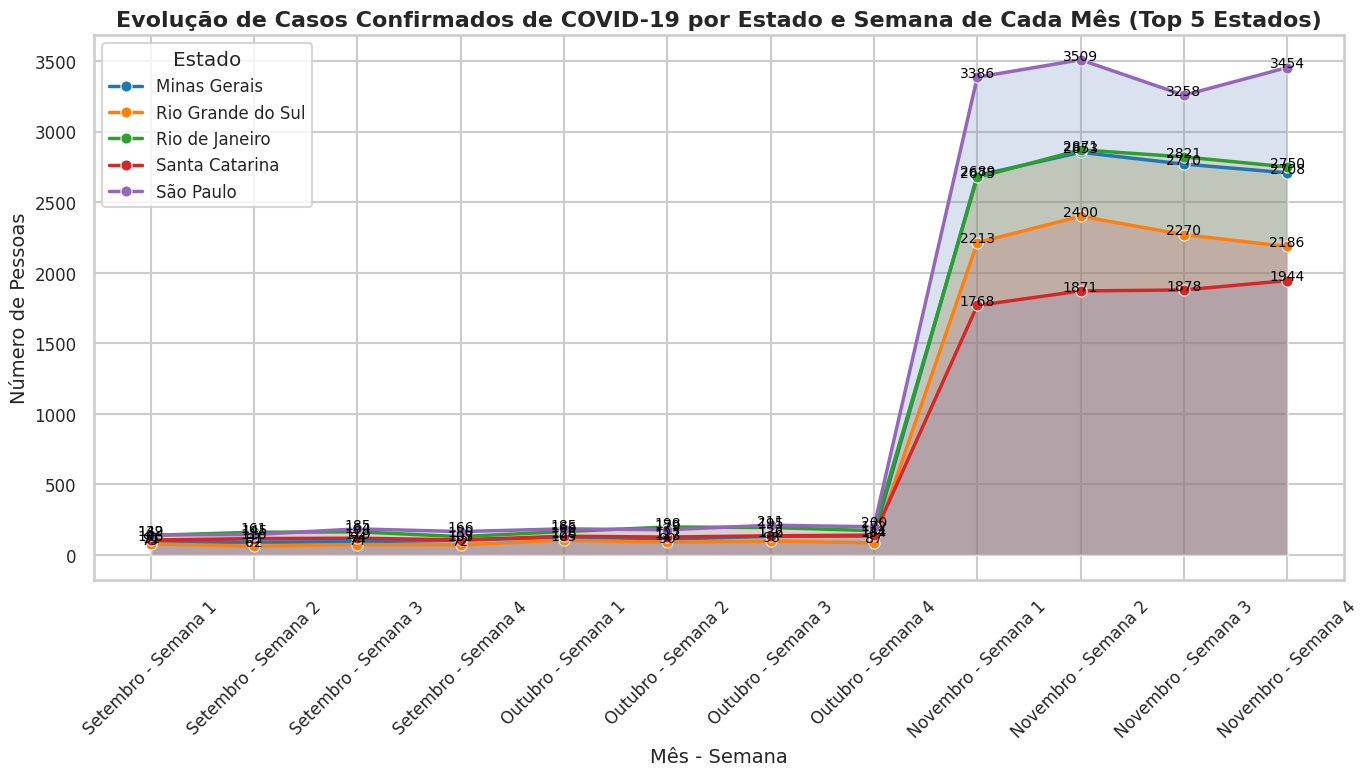

In [71]:
# Filtrando apenas os casos em que a pessoa teve COVID-19 confirmado
df_filtrado_covid = df_pandas[df_pandas['teve_covid'] == 'Sim']

# Agrupando por estado, mês e semana para obter a contagem de casos confirmados de COVID-19
df_estado_covid = df_filtrado_covid.groupby(['estado', 'mes', 'semana']).size().reset_index(name='count')

# Obtendo os 5 estados com mais casos confirmados de COVID-19
top5_estados = df_estado_covid.groupby('estado')['count'].sum().nlargest(5).index.tolist()

# Filtrando o DataFrame apenas para os top 5 estados
df_top5_estados = df_estado_covid[df_estado_covid['estado'].isin(top5_estados)]

# Converter os números dos meses para nomes dos meses em português
meses_nome = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril',
    5: 'Maio', 6: 'Junho', 7: 'Julho', 8: 'Agosto',
    9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'
}
df_top5_estados['mes_nome'] = df_top5_estados['mes'].map(meses_nome)

# Criando a coluna 'mes_semana' para facilitar o plot
df_top5_estados['mes_semana'] = df_top5_estados['mes_nome'] + ' - Semana ' + df_top5_estados['semana'].astype(str)

# Ordenando o DataFrame por estado, mês e semana para garantir a sequência correta
df_top5_estados = df_top5_estados.sort_values(['estado', 'mes', 'semana'])

# Criando o gráfico de linhas para mostrar a evolução de casos confirmados por estado e semana do mês
plt.figure(figsize=(14, 8))
ax = sns.lineplot(
    data=df_top5_estados,
    x='mes_semana', y='count',
    hue='estado', marker='o', 
    markersize=8, linewidth=2.5,
    palette='tab10'
)

# Adicionando área de preenchimento sob a curva para destaque
for state in top5_estados:
    subset = df_top5_estados[df_top5_estados['estado'] == state]
    ax.fill_between(subset['mes_semana'], subset['count'], alpha=0.2)

# Adicionando rótulos e título ao gráfico
plt.title('Evolução de Casos Confirmados de COVID-19 por Estado e Semana de Cada Mês (Top 5 Estados)', fontsize=16, fontweight='bold')
plt.xlabel('Mês - Semana', fontsize=14)
plt.ylabel('Número de Pessoas', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Estado', fontsize=12)

# Adicionando valores nos pontos da linha para cada estado
for state in top5_estados:
    subset = df_top5_estados[df_top5_estados['estado'] == state]
    for index, row in subset.iterrows():
        plt.text(row['mes_semana'], row['count'] + 0.5, f"{int(row['count'])}", color='black', ha="center", fontsize=10)

# Ajustar layout e exibir o gráfico
plt.tight_layout()
plt.show()


# Evolução de Casos Confirmados de COVID-19 por Estado e Semana de Cada Mês (Top 5 Estados)

O gráfico apresenta a evolução semanal dos casos confirmados de COVID-19 nos cinco estados mais afetados. Os dados analisados abrangem os meses de setembro, outubro e novembro, evidenciando um aumento significativo a partir da última semana de outubro.

- **São Paulo** é o estado com o maior número de casos confirmados, apresentando um pico de 3.509 casos na primeira semana de novembro.
- **Minas Gerais** também mostra uma tendência crescente, alcançando 2.871 casos na terceira semana de novembro.
- **Rio Grande do Sul**, **Rio de Janeiro** e **Santa Catarina** seguem com aumentos mais moderados, mas ainda assim expressivos.

Este gráfico permite observar como a pandemia se desenvolveu em cada estado ao longo do tempo, fornecendo informações essenciais para identificar a necessidade de medidas adicionais em regiões com maior crescimento de casos. Apesar das informações serem relevantes, ressalta-se que podem haver subnotificações de casos não registrados oficialmente.


## Conclusão e Recomendações Executivas

A análise dos gráficos revela que a COVID-19 impactou diferentes grupos sociais e regiões de forma significativa. Observa-se que **49% dos casos confirmados** estão concentrados em pessoas de baixa escolaridade e que **70% das pessoas** com sintomas ou casos confirmados de COVID-19 pertencem às faixas etárias de **18 a 59 anos**. No aspecto regional, **São Paulo e Minas Gerais** foram os estados com o maior número de casos confirmados, correspondendo juntos a mais de **30% dos casos analisados**.

A pesquisa demonstra uma **subnotificação potencial**, pois algumas pessoas podem não ter procurado atendimento médico ou não notificaram a doença, o que poderia indicar que o impacto real é ainda maior do que os números apresentados.

### Recomendações para Ação Governamental:
1. **Campanhas de conscientização** direcionadas para jovens e pessoas com menor nível educacional, que compõem 70% dos casos, focando na importância de notificar sintomas e seguir medidas preventivas.
2. **Distribuição de recursos e apoio a estados mais afetados**, como São Paulo (15% dos casos confirmados) e Minas Gerais (13% dos casos confirmados), para intensificar o controle de surtos e aumentar a capacidade hospitalar.
3. **Apoio às comunidades vulneráveis**, considerando que 75% das pessoas sem plano de saúde que tiveram COVID-19 buscaram atendimento em postos de saúde, destacando a necessidade de acesso universal a cuidados médicos.
4. **Monitoramento constante** nas regiões com crescimento semanal acelerado de casos, para implementar medidas de restrição temporárias e controlar o avanço da pandemia.

Essas estratégias são essenciais para reduzir a transmissão e proteger a população mais vulnerável, minimizando o impacto da pandemia e garantindo uma resposta eficiente do sistema de saúde a potenciais novos surtos.
